# Calibrate Cameras
[https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html](https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html)

In [2]:
from models.dataset.dataset_interface import DatasetInterface
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import cv2

# Rectify

In [3]:
resource_path = Path("../../resources")
uncal_path = resource_path / "images/uncalibrated"
cal_path = Path(resource_path / "images/calibrated/rectified")
cal_dataset_interface = DatasetInterface(uncal_path / "dataset_1/calibration_gt")

sift = cv2.SIFT_create()
index_params = dict(algorithm = 1, trees = 5)
search_params = dict(checks=50)


## Fallback Rectification With Charuco

Size: 45


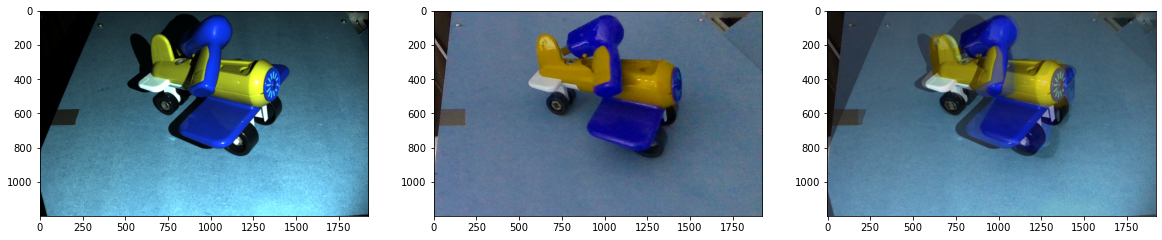

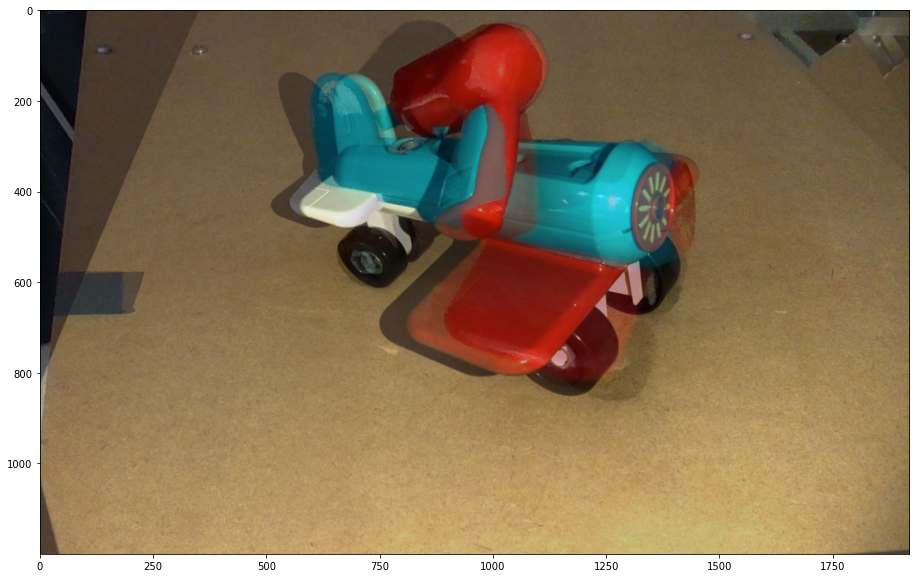

In [164]:
idx_to_visualize = -1 
dir_to_preprocess = Path("dataset_4")
dataset_interface = DatasetInterface(uncal_path / dir_to_preprocess, recursive=False)

print(f"Size: {len(dataset_interface)}")

obj = []
scene = []

for rs_rgb, rs_depth, zv_rgb, zv_depth in cal_dataset_interface:
    zv_kp, zv_des = sift.detectAndCompute(zv_rgb, None)
    rs_kp, rs_des = sift.detectAndCompute(rs_rgb, None)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(zv_des, rs_des, k=2)

    #-- Filter matches using the Lowe's ratio test
    ratio_thresh = 0.7
    good_matches = [m for m,n in matches if m.distance < ratio_thresh * n.distance]

    #-- Localize the object
    for i in range(len(good_matches)):
        #-- Get the keypoints from the good matches
        obj.append(zv_kp[good_matches[i].queryIdx].pt)
        scene.append(rs_kp[good_matches[i].trainIdx].pt)

    break

obj = np.array(obj)
scene = np.array(scene)
fallback_H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC)
fallback_H_inv = np.linalg.inv(fallback_H)
#-- Draw matches
# img_matches = np.empty((max(zv_rgb.shape[0], rs_rgb.shape[0]), zv_rgb.shape[1] + zv_rgb.shape[1], 3), dtype=np.uint8)
# cv2.drawMatches(zv_rgb, zv_kp, rs_rgb, rs_kp, good_matches, img_matches, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# #-- Get the corners from the image_1 ( the object to be "detected" )
# obj_corners = np.empty((4,1,2), dtype=np.float32)
# obj_corners[0,0,0] = 0
# obj_corners[0,0,1] = 0
# obj_corners[1,0,0] = zv_rgb.shape[1]
# obj_corners[1,0,1] = 0
# obj_corners[2,0,0] = zv_rgb.shape[1]
# obj_corners[2,0,1] = zv_rgb.shape[0]
# obj_corners[3,0,0] = 0
# obj_corners[3,0,1] = zv_rgb.shape[0]
# scene_corners = cv2.perspectiveTransform(obj_corners, H)
# #-- Draw lines between the corners (the mapped object in the scene - image_2 )
# cv2.line(img_matches, (int(scene_corners[0,0,0] + zv_rgb.shape[1]), int(scene_corners[0,0,1])),\
#     (int(scene_corners[1,0,0] + zv_rgb.shape[1]), int(scene_corners[1,0,1])), (0,255,0), 4)
# cv2.line(img_matches, (int(scene_corners[1,0,0] + zv_rgb.shape[1]), int(scene_corners[1,0,1])),\
#     (int(scene_corners[2,0,0] + zv_rgb.shape[1]), int(scene_corners[2,0,1])), (0,255,0), 4)
# cv2.line(img_matches, (int(scene_corners[2,0,0] + zv_rgb.shape[1]), int(scene_corners[2,0,1])),\
#     (int(scene_corners[3,0,0] + zv_rgb.shape[1]), int(scene_corners[3,0,1])), (0,255,0), 4)
# cv2.line(img_matches, (int(scene_corners[3,0,0] + zv_rgb.shape[1]), int(scene_corners[3,0,1])),\
#     (int(scene_corners[0,0,0] + zv_rgb.shape[1]), int(scene_corners[0,0,1])), (0,255,0), 4)
# plt.imshow(img_matches)
#-- Show detected matches

fallback_rectified_frames = []
for rs_rgb, rs_depth, zv_rgb, zv_depth in dataset_interface:
    rs_rgb_warp = cv2.warpPerspective(rs_rgb, fallback_H_inv, (zv_rgb.shape[1], zv_rgb.shape[0]))
    rs_depth_warp = cv2.warpPerspective(rs_depth, fallback_H_inv, (zv_rgb.shape[1], zv_rgb.shape[0]))
    fallback_rectified_frames.append((rs_rgb_warp, rs_depth_warp, zv_rgb, zv_depth))
    # calibrated_dc.append_and_save(rs_rgb_warp, rs_depth_warp, zv_rgb, zv_depth)

# debug output
_, axarr = plt.subplots(1, 3, figsize=(20, 10))
axarr[0].imshow(fallback_rectified_frames[idx_to_visualize][2])
axarr[1].imshow(fallback_rectified_frames[idx_to_visualize][0])
img_both = cv2.addWeighted(fallback_rectified_frames[idx_to_visualize][0], 0.5, 
                        fallback_rectified_frames[idx_to_visualize][2], 0.5, 0)
axarr[2].imshow(img_both)

plt.figure(2, figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_both, cv2.COLOR_BGR2RGB))

## Per-Image Rectification with Features

In [165]:
feature_rectified_frames = []
feature_H_inv = []
white = np.ones((1920, 1200, 3))
for rs_rgb, rs_depth, zv_rgb, zv_depth in dataset_interface:
    zv_kp, zv_des = sift.detectAndCompute(zv_rgb, None)
    rs_kp, rs_des = sift.detectAndCompute(rs_rgb, None)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(zv_des, rs_des, k=2)

    #-- Filter matches using the Lowe's ratio test
    ratio_thresh = 0.7
    good_matches = [m for m,n in matches if m.distance < ratio_thresh * n.distance]

    #-- Localize the object
    obj = []
    scene = []
    for i in range(len(good_matches)):
        #-- Get the keypoints from the good matches
        obj.append(zv_kp[good_matches[i].queryIdx].pt)
        scene.append(rs_kp[good_matches[i].trainIdx].pt)


    if len(obj) >= 4:
        obj = np.array(obj)
        scene = np.array(scene)
        H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC)
        if H is None:
            feature_rectified_frames.append((white, white, white, white))
            feature_H_inv.append(-1)

        else:
            H_inv = np.linalg.inv(H)
            rs_rgb_warp = cv2.warpPerspective(rs_rgb, H_inv, (zv_rgb.shape[1], zv_rgb.shape[0])).astype(np.uint8)
            rs_depth_warp = cv2.warpPerspective(rs_depth, H_inv, (zv_rgb.shape[1], zv_rgb.shape[0])).astype(np.uint8)
            feature_rectified_frames.append((rs_rgb_warp, rs_depth_warp, zv_rgb, zv_depth))
            feature_H_inv.append(H_inv)
    else: # not enough features detected
        feature_rectified_frames.append((white, white, white, white))
        feature_H_inv.append(-1)

## Compare Calibrated Fallback to Feature Images in batches

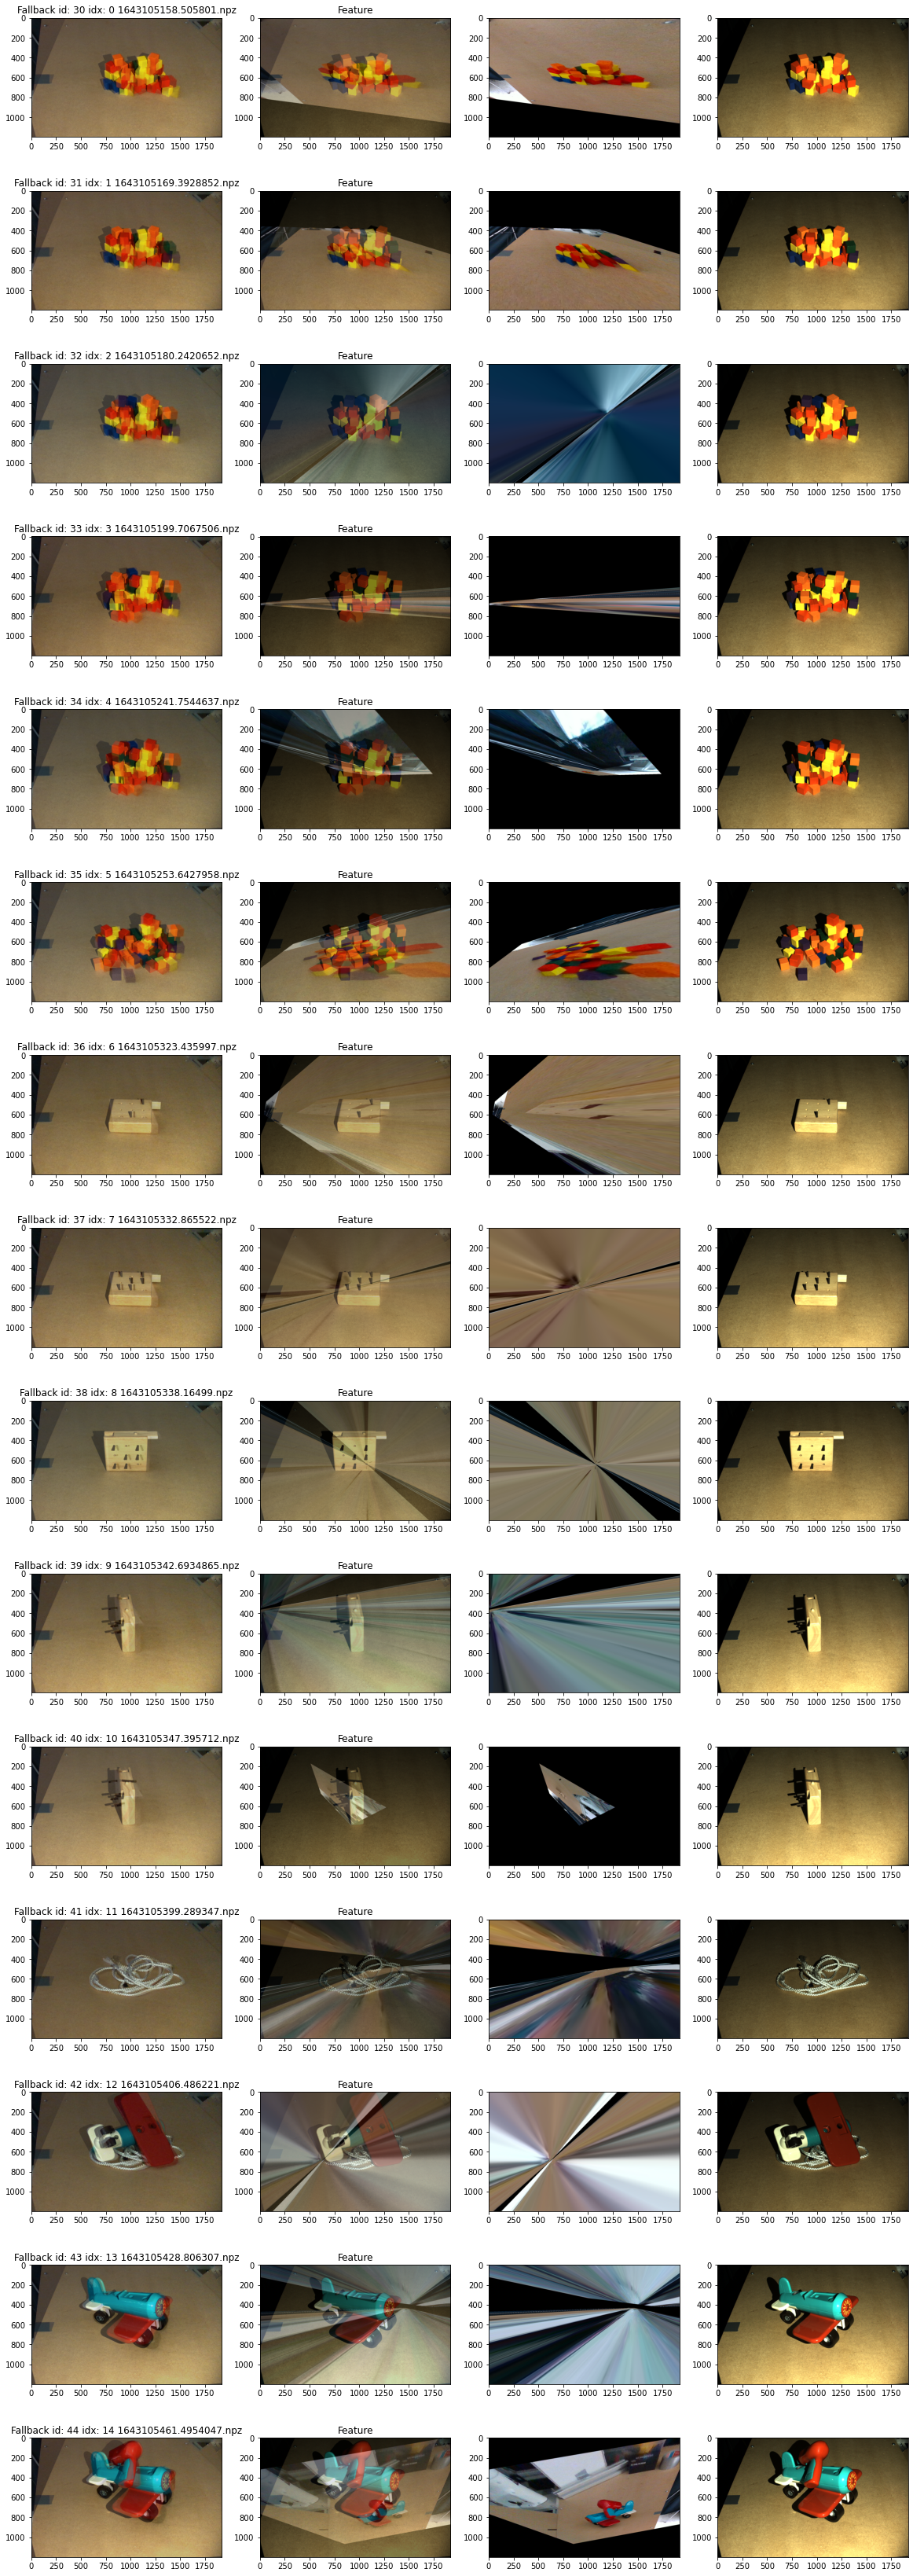

In [185]:
from_idx = 30
to_idx = 45 # len(dataset_interface)

_, axarr = plt.subplots(to_idx - from_idx, 4, figsize=(4 * 5, (to_idx - from_idx) * 4))

for i in range(from_idx, to_idx):
    (fb_rs_rgb, _, fb_zv_rgb, _) = fallback_rectified_frames[i]
    (fe_rs_rgb, _, fe_zv_rgb, _) = feature_rectified_frames[i]
    axarr[i - from_idx][0].title.set_text(f"Fallback id: {i} idx: {i - from_idx} {dataset_interface.data_file_paths[i].name}")
    axarr[i - from_idx][0].imshow(cv2.cvtColor(cv2.addWeighted(fb_rs_rgb, 0.5, fb_zv_rgb, 0.5, 0), cv2.COLOR_BGR2RGB))
    axarr[i - from_idx][1].title.set_text(f"Feature")
    axarr[i - from_idx][1].imshow(cv2.cvtColor(cv2.addWeighted(fe_rs_rgb.astype(np.uint8), 0.5, fe_zv_rgb.astype(np.uint8), 0.5, 0), cv2.COLOR_BGR2RGB))
    axarr[i - from_idx][2].imshow(cv2.cvtColor(fe_rs_rgb.astype(np.uint8), cv2.COLOR_BGR2RGB))
    axarr[i - from_idx][3].imshow(cv2.cvtColor(dataset_interface[i][2], cv2.COLOR_BGR2RGB))

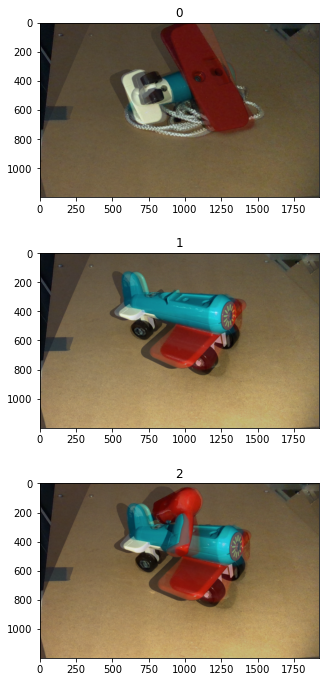

In [193]:
from_idx = 42
to_idx = 45

H_to_use = [
    # 0,  1,  2,  3,  4,  5   6,  7,  8,  9
     -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, # 0 - 9
    #10, 11, 12, 13, 14, 15, 16, 17, 18, 19
     -1, -1, -1, -1, 14, 15, 16, 17, -1, -1
]

calibrated_frames = []
_, axarr = plt.subplots(to_idx - from_idx, 1, figsize=(5, (to_idx - from_idx) * 4))

for i, (rs_rgb, rs_depth, zv_rgb, zv_depth) in enumerate(dataset_interface[from_idx:to_idx]):
    if H_to_use[i] == -1:
        H_inv = fallback_H_inv
    else:
        H_inv = feature_H_inv[H_to_use[i] + from_idx]

    rs_rgb_warp = cv2.warpPerspective(rs_rgb, H_inv, (zv_rgb.shape[1], zv_rgb.shape[0]))
    rs_depth_warp = cv2.warpPerspective(rs_depth, H_inv, (zv_rgb.shape[1], zv_rgb.shape[0]))
    calibrated_frames.append((rs_rgb_warp, rs_depth_warp, zv_rgb, zv_depth))
    axarr[i].title.set_text(f"{i}")
    axarr[i].imshow(cv2.cvtColor(cv2.addWeighted(rs_rgb_warp, 0.5, zv_rgb, 0.5, 0), cv2.COLOR_BGR2RGB))

In [191]:
calibrated_dc = DatasetInterface(cal_path / dir_to_preprocess / "plane")
for i, (rs_rgb, rs_depth, zv_rgb, zv_depth) in enumerate(calibrated_frames):
    calibrated_dc.append_and_save(rs_rgb, rs_depth, zv_rgb, zv_depth, 
    Path(dataset_interface.data_file_paths[i + from_idx].name))